In [1]:
import rasterio
import geopandas as gpd
from fastai.vision import *
from rasterio import features
from shapely.geometry import mapping
from rasterio.plot import show

In [2]:
images=get_image_files(Path('/home/staff/xin/Downloads/building/AOI_4_Shanghai_Train/RGB-PanSharpen/'))

In [3]:
shppath=Path('/home/staff/xin/Downloads/building/AOI_4_Shanghai_Train/geojson/buildings/')

In [4]:
i=100


In [9]:
imagename=images[i]
shpname=shppath/images[i].name.replace('RGB-PanSharpen','buildings').replace('.tif','.geojson')
print(shpname)

/home/staff/xin/Downloads/building/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img1495.geojson


In [10]:
image=rasterio.open(imagename)
shp=gpd.read_file(shpname)

In [11]:
shp.head()

,OBJECTID_2,OBJECTID,AREA,Shape_Leng,Shape_Area,partialBuilding,partialDec,geometry
0,0,0,0.0,0.0,589.929501,1.0,0.220254,POLYGON Z ((121.6281669543867 31.3189659000482...
1,0,0,0.0,0.0,384.437559,1.0,0.692602,POLYGON Z ((121.6272013464701 31.3189948250183...
2,0,0,0.0,0.0,32.888276,0.0,1.000000,POLYGON Z ((121.6273985904553 31.3190472581167...
3,0,0,0.0,0.0,92.792366,0.0,1.000000,POLYGON Z ((121.6276909821988 31.3192338034921...
4,0,0,0.0,0.0,614.481693,1.0,0.815031,POLYGON Z ((121.6287791999829 31.3191437791763...


In [31]:
for i in range(len(shp)):
    shp.iat[i,1]=i+1

In [34]:
image.transform

Affine(2.7000000000043656e-06, 0.0, 121.6270242,
       0.0, -2.7000000000043656e-06, 31.3207209)

In [40]:
burn = features.rasterize((((mapping(g)), value) for g, value in  zip(shp.geometry, shp.OBJECTID)), out_shape=image.shape,
        transform=image.transform,all_touched=True)

In [130]:
burn.shape

(650, 650)

In [2]:
import tqdm
import skimage.io as io

In [13]:
def stretch_8bit(bands, lower_percent=1, higher_percent=99):
    out = np.zeros_like(bands,dtype='float32')   
    a = 0 
    b = 255 
    for i in range(bands.shape[0]):
        c = np.percentile(bands[i], lower_percent)
        d = np.percentile(bands[i], higher_percent)
        t = a + (bands[i] - c) * (b - a) / (d - c)    
        t[t<a] = a
        t[t>b] = b
        out[i] =t
    return out.astype(np.uint8) 

In [3]:
import warnings

warnings.filterwarnings('ignore')

In [22]:
from skimage.morphology import square,binary_erosion
def proimg(temp):
#     i=1
    result=np.zeros_like(temp)
    for num in np.unique(temp):
        if num!=0:
            tt=temp==num
            tt=binary_erosion(tt)
            result[tt]=1
#             i=i+1
    return result.astype('uint8')

In [16]:
mins=[]
maxs=[]
savepath=Path('/home/staff/xin/Downloads/building/images/')
for image in tqdm.tqdm(images):
    shpname=shppath/image.name.replace('RGB-PanSharpen','buildings').replace('.tif','.geojson')
    shp=gpd.read_file(shpname)
    if len(shp)>0:
        temp1=rasterio.open(image)
        temp=temp1.read()
        temp=stretch_8bit(temp)
        name=image.name.split('_')[-1].replace('tif','jpg')
        io.imsave(savepath/name,temp.transpose(1,2,0))
        label=name.replace('jpg','png')
        for i in range(len(shp)):
            shp.iat[i,1]=i+1
        burn = features.rasterize((((mapping(g)), value) for g, value in  zip(shp.geometry, shp.OBJECTID)), out_shape=temp1.shape,
            transform=temp1.transform,all_touched=True)
        burn=proimg(burn)
        io.imsave(savepath/label,burn)
#         print(name,label)
#         break
    
    
    

100%|██████████| 4582/4582 [10:56<00:00,  6.98it/s]


In [8]:
from pycocotools import mask as cocomask
def get_annotations(fname, prefix=None):
    "Open a COCO style json in `fname` and returns the lists of filenames (with maybe `prefix`) and labelled bboxes."
    annot_dict = json.load(open(fname))
    id2images, id2bboxes, id2cats = {}, collections.defaultdict(list), collections.defaultdict(list)
    classes = {}
    for o in annot_dict['categories']:
        classes[o['id']] = o['name']
    for o in annot_dict['annotations']:
        bb = o['segmentation']
        rle = cocomask.frPyObjects(bb, 300, 300)
        id2bboxes[o['image_id']].append(rle)
        id2cats[o['image_id']].append(classes[o['category_id']])
    for o in annot_dict['images']:
        if o['id'] in id2bboxes:
            id2images[o['id']] = ifnone(prefix, '') + o['file_name']
    ids = list(id2images.keys())
    return [id2images[k] for k in ids], [[id2bboxes[k], id2cats[k]] for k in ids]

In [37]:
xx=get_annotations('/home/staff/xin/Downloads/building/val/annotation.json')

In [38]:
path=Path('/home/staff/xin/Downloads/building/val/images/')
# newpath=Path('/home/staff/xin/Downloads/building/images/')
import shutil

In [35]:
def proessimg(i,value):
    i=value
    filename=xx[0][i]
    pngname=filename.replace('jpg','png')
    masks=np.zeros((300,300),dtype='uint8')
    for m in range(len(xx[1][i][1])):
        rle=xx[1][i][0][m]
        mask=cocomask.decode(rle)
        mask=mask[:,:,0]
        mask=binary_erosion(mask)
        masks[mask>0]=1
#     print(path/pngname)
    io.imsave(path/pngname,masks)

In [28]:
# for i in tqdm.trange(len(xx[0])):
#     proessimg(i)

In [39]:
parallel(proessimg,[i for i in range(len(xx[0]))])

In [8]:
for i in tqdm.trange(len(xx[0])):
    filename=xx[0][i]
#     print(path/filename)
#     shutil.move(path/filename,newpath/filename)
    pngname=filename.replace('jpg','png')
    masks=np.zeros((300,300),dtype='uint8')
    for m in range(len(xx[1][i][1])):
        rle=xx[1][i][0][m]
        mask=cocomask.decode(rle)
        mask=mask[:,:,0]
        mask=binary_erosion(mask)
        masks[mask>0]=1
    io.imsave(newpath/pngname,masks)
#     break

 13%|█▎        | 37746/280741 [03:32<23:08, 175.04it/s]

KeyboardInterrupt: 

In [8]:
import skimage.io as io

ModuleNotFoundError: No module named 'Path'

In [14]:
a=io.imread('/home/staff/xin/Downloads/building/images/'+xx[0][100])

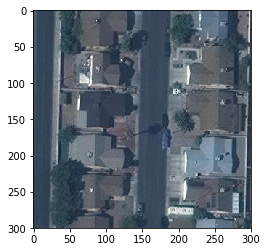

In [15]:
plt.imshow(a)

In [24]:
masks=np.zeros((300,300),dtype='uint8')
for m in range(len(xx[1][100][1])):
    rle=xx[1][100][0][m]
    mask=cocomask.decode(rle)
    mask=mask[:,:,0]
    mask=binary_erosion(mask)
    masks[mask>0]=1

In [5]:
imgs=os.listdir('/home/staff/xin/Downloads/building/images/')

In [7]:
for img in tqdm.tqdm(imgs):
    if img[0]=='0':
        os.remove(os.path.join('/home/staff/xin/Downloads/building/images/',img))

100%|██████████| 568194/568194 [00:09<00:00, 61305.33it/s]


In [10]:
xx[0][0]

'000000048622.jpg'

In [11]:
xx[0][1]

'000000022778.jpg'

In [1]:
import torch

In [5]:
xx=0.5

In [12]:
xx=torch.tensor(0.8)

In [13]:
yy=xx.exp()

In [14]:
yy

tensor(2.2255)